In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
import matplotlib.animation
writervideo = matplotlib.animation.FFMpegWriter(fps=30)

import numpy as np
import pandas as pd

import pims
import trackpy as tp
tp.quiet()
from PIL import Image, ImageDraw
import cv2

from tqdm import tqdm
import timeit

import random

run_analysis_verb = True
plot_verb = False

# PRE PROCESSING

In [2]:
@pims.pipeline
def crop(image, x1, y1, x2, y2):
    npImage = np.array(image)
    
    # Create same size alpha layer with circle
    alpha = Image.new('L', (720, 720), 0)
    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)

    # Convert alpha Image to numpy arrayf
    npAlpha = np.array(alpha)
    npImage = npImage[:,:,1] * npAlpha
    
    ind = np.where(npImage == 0)
    # npImage[150, 150] color of the border to swap with the black
    npImage[ind] = npImage[150, 150]
    return npImage

@pims.pipeline
def crop2(image, x1, y1, x2, y2):    
    npImage = np.array(image)
    # Create same size alpha layer with circle
    #alpha = Image.new('L', (920, 960), 0)
    alpha = Image.new('L', (920, 960), 0)

    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)

    # Convert alpha Image to numpy arrayf
    npAlpha = np.array(alpha)
    npImage = npImage[:, :, 1] * npAlpha
    
    ind = np.where(npImage == 0)
    # npImage[200, 200] color of the border to swap with the black
    npImage[ind] = npImage[200, 200]
    return npImage

In [3]:
data = crop2(pims.open('../data/tracking/movie.mp4'), 55, 55, 880, 880)
data_ref = pims.open('../data/tracking/movie.mp4')

deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure you did set range correctly


In [4]:
if plot_verb:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(data[0])
    ax2.imshow(data_ref[0])
    plt.tight_layout()
    plt.show()

# TRACKING 

In [5]:
# parameters of the tracking
dropSize = 31  
minMass = 2000
sep = 16
nDrops = 50

In [10]:
# FEATURES LOCATION

nFrames = 100 # total number of frames of video --> len(data)
f = tp.batch(data[32268:32268+nFrames], dropSize, minmass = minMass, separation = sep, topn = nDrops, engine = 'numba')    
display(f)

deprecated pixel format used, make sure you did set range correctly
 (repeated 55 more times)
deprecated pixel format used, make sure you did set range correctly


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,208.247267,430.519147,9893.994285,10.067971,0.037080,20.673693,80851.0,0.002009,0
1,210.476519,355.737765,10338.369878,10.062333,0.025003,20.673693,81092.0,0.001991,0
2,208.467324,468.012643,10069.611868,10.318614,0.080197,18.932751,81057.0,0.001994,0
3,208.562808,505.304960,9968.201963,10.324260,0.053565,20.891311,80694.0,0.002021,0
4,215.485929,543.071499,9983.217593,10.462707,0.078948,20.673693,81131.0,0.001989,0
...,...,...,...,...,...,...,...,...,...
4926,677.658315,494.303494,11037.368431,10.433124,0.041993,20.679017,88652.0,0.001159,99
4927,694.769759,530.376394,10658.328869,10.378664,0.030475,20.451775,87598.0,0.001195,99
4928,709.451972,377.569227,10837.395521,10.279193,0.094099,23.860404,87377.0,0.001203,99
4929,719.946295,432.307803,11657.284452,10.558324,0.045295,22.042469,88083.0,0.001178,99


In [11]:
# ANOMALIES DETECTION

num = np.zeros(nFrames)
for i in range(nFrames):
    num[i] = len(f.loc[f['frame'] == i])

idx = np.where(num != nDrops)[0]
print(idx)

if len(idx) != 0:
    delta = np.zeros(len(idx)-1)
    for i in range(len(idx)-1):
        delta[i] = idx[i+1]-idx[i]
    print(delta)

[ 1  2  5  7  8  9 10 11 12 19 20 21 25 26 31 32 33 34 35 36 37 41 42 43
 45 46 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69
 70 71 72 73 74 75 77 78 79 80 81 82 83 84 85 88 89 91 92 93 99]
[1. 3. 2. 1. 1. 1. 1. 1. 7. 1. 1. 4. 1. 5. 1. 1. 1. 1. 1. 1. 4. 1. 1. 2.
 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 2. 1. 1. 6.]


In [12]:
# FEATURES LINKING

t = tp.link_df(f, 150, memory = 2, link_strategy = 'hybrid', neighbor_strategy = 'KDTree', adaptive_stop = 1)
display(t)

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,208.247267,430.519147,9893.994285,10.067971,0.037080,20.673693,80851.0,0.002009,0,0
27,504.661295,709.382669,10236.307120,10.366538,0.078809,20.238457,84864.0,0.001749,0,1
28,510.472957,214.295968,10815.170527,10.445846,0.037095,21.544164,85493.0,0.001714,0,2
29,540.254727,702.688291,10174.068423,10.468882,0.088458,19.585604,86396.0,0.001667,0,3
30,547.530726,231.499529,9703.143455,10.181751,0.012416,20.456075,85519.0,0.001713,0,4
...,...,...,...,...,...,...,...,...,...,...
4901,358.072900,705.699342,9884.570052,10.246568,0.073742,19.770049,83076.0,0.001380,99,44
4902,385.267064,209.147536,9914.565989,10.236033,0.024998,20.224533,84343.0,0.001323,99,41
4903,394.001223,714.382735,9658.237077,10.254978,0.098333,18.861081,81767.0,0.001445,99,42
4892,262.004104,356.622471,11073.499900,10.472875,0.024965,19.542807,81730.0,0.001447,99,37


In [13]:
n = max(t.particle)
print(n)
random.seed(5)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
for i in range(max(t.particle)+1-n):
    colors.append("#00FFFF")
c = []
for p in t.particle:
    c.append(colors[p])
t["color"] = c


61


In [14]:
lost_particles = []
for i in tqdm(range(nFrames-1)):
    a = t.loc[t.frame == i].sort_values('particle').particle.values
    b = t.loc[t.frame == i+1].sort_values('particle').particle.values
    ind = np.where(np.in1d(a, b)==False)[0]
    if ind.size > 0:
        lost_particles.append([i, a[ind]])

print("Total problems:", len(lost_particles))
if len(lost_particles) > 0: 
    print(f"First failure occurred at frame {lost_particles[0][0]}")
    f1 = lost_particles[0][0]
    f2 = lost_particles[0][0]+1
    print(t.loc[t.frame == f1].sort_values('particle').particle.values)
    print(t.loc[t.frame == f2].sort_values('particle').particle.values)

100%|██████████| 99/99 [00:00<00:00, 357.18it/s]

Total problems: 20
First failure occurred at frame 0
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]


deprecated pixel format used, make sure you did set range correctly
 (repeated 31867 more times)
deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure you did set range correctly


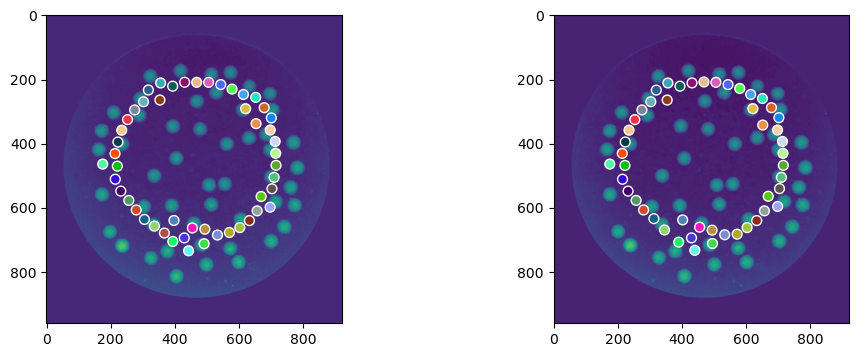

In [15]:
if len(lost_particles)>0: 
    fig, (ax, ax1) = plt.subplots(1, 2)
    df = t.loc[t['frame'] == f1, ["x", "y", "color", "particle"]]
    ax.scatter(df.x, df.y, s=50, ec = "w", facecolor = df.color)
    #ax.scatter(df.loc[df.particle==43].x, df.loc[df.particle==43].y, s=100)
    #ax.scatter(df.loc[df.particle==82].x, df.loc[df.particle==82].y, s=100)
    ax.imshow(data[f1])

    df1 = t.loc[t['frame'] == f2, ["x", "y", "color"]]
    ax1.scatter(df1.x, df1.y, s=50, ec = "w", facecolor = df1.color)
    ax1.imshow(data[f2])

    plt.show()

In [ ]:
t1 = tp.filter_stubs(t, 80000)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

In [ ]:
plt.figure()
tp.plot_traj(t1)
plt.show()

In [ ]:
plt.figure()
plt.title(f"1: {len(t1[t1['particle'] == 0].x)}")
plt.plot(t1[t1['particle'] == 0].x, t1[t1['particle'] == 0].y, linewidth=.1)
plt.plot(t1[t1['particle'] == 1].x, t1[t1['particle'] == 1].y, linewidth=.1)
plt.plot(t1[t1['particle'] == 2].x, t1[t1['particle'] == 2].y, linewidth=.1)
plt.show()

In [ ]:
df = rawTrajs.loc[(rawTrajs.frame == 0) , ["x", "y", "color"]]
fig, ax = plt.subplots(1,1)
ax.scatter(df.x, df.y, facecolors = 'none', edgecolors = df.color, s = 150)
ax.imshow(data[0])
if save_verb: plt.savefig("../results/location_example.png", dpi=500, bbox_inches='tight')
if show_verb: 
    plt.show()
else:
    plt.close()

fig = plt.figure()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(frame):
    df = rawTrajs.loc[(rawTrajs.frame == frame) & (rawTrajs.particle == red_particle_idx) , ["x","y","color"]]
    graph.set_offsets(df)
    graph.set_edgecolor(df.color)
    graph2.set_data(data[frame])
    title.set_text('frame = {}'.format(frame))
    return graph

ax = fig.add_subplot(111)
title = ax.set_title('frame = 0')
df = rawTrajs.loc[(rawTrajs.frame == 0) & (rawTrajs.particle == red_particle_idx), ["x","y","color"]]

graph = ax.scatter(df.x, df.y, facecolors = 'none', edgecolors = df.color, s = 150)

graph2 = ax.imshow(data[0])

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, 100, interval = 5, blit=False)
if 0: ani.save('../results/video/tracking.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if anim_show_verb:
    plt.show()
else:
    plt.close()


# MERGING ANALYSIS

In [ ]:
preMerge = data[32268]
merge = data[32269]
postMerge = data[32270]

# feature location with minMass, have some problems but the spurious effect are solved
f = tp.locate(preMerge, dropSize, minmass = minMass, separation = sep, topn = nDrops, engine = 'numba')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(f['mass'], bins = 20)
ax1.set(xlabel='mass', ylabel='count')
ax2.imshow(preMerge)
ax2.plot(f.x, f.y, 'bo')
plt.suptitle(f"Number of features found: {len(f)}")
plt.show()

f = tp.locate(merge, dropSize, minmass = minMass, separation = sep, topn = nDrops-1, engine = 'numba')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(f['mass'], bins = 20)
ax1.set(xlabel='mass', ylabel='count')
ax2.imshow(merge)
ax2.plot(f.x, f.y, 'bo')
plt.suptitle(f"Number of features found: {len(f)}")

f = tp.locate(postMerge, dropSize, minmass = minMass, separation = sep, topn = nDrops-1, engine = 'numba')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(f['mass'], bins = 20)
ax1.set(xlabel='mass', ylabel='count')
ax2.imshow(postMerge)
ax2.plot(f.x, f.y, 'bo')
plt.suptitle(f"Number of features found: {len(f)}")

plt.show()
tp.subpx_bias(f)
plt.show()